# 🎓 Session 2: Coding Attention Mechanisms

**Workshop: Build a Large Language Model From Scratch**  
**Duration**: 3 hours (1:30 PM - 4:30 PM)  
**Instructor Notes**: 📢 indicates what to say, 💡 indicates key points to emphasize

---

## 📋 Session Overview

| Time | Topic | Type |
|------|-------|------|
| 1:30 - 2:00 | Attention Intuition | Theory |
| 2:00 - 3:00 | Self-Attention from Scratch | Hands-on |
| 3:00 - 3:15 | Break | - |
| 3:15 - 4:15 | Multi-Head Attention | Hands-on |
| 4:15 - 4:30 | Exercises & Recap | Practice |

---
# Part 1: Understanding Attention (30 min)
---

## 📢 Instructor Script

> "Welcome back everyone! This session is the heart of our workshop. We're going to build the **Attention Mechanism** - the revolutionary idea that made transformers possible!"

> "The 2017 paper 'Attention Is All You Need' changed everything. Let's understand why!"

## 🤔 Why Do We Need Attention?

📢 **Say this (draw on whiteboard):**
> "Imagine translating 'The cat sat on the mat' to French. When translating 'chat' (cat), you need to look back at 'The' and 'cat'. Different words need to pay attention to different parts of the sentence!"

**The Problem with RNNs:**
```
RNN: The → cat → sat → on → the → mat → [compressed vector] → output
                                               ↑
                        All information crammed into one vector!
```

**The Attention Solution:**
```
Attention: When outputting each word, look at ALL input words
           and decide which ones are most relevant!
```

## 🎯 Self-Attention: The Core Idea

📢 **Say this:**
> "Self-attention lets each word look at every other word and ask: 'How relevant are you to me?'"

💡 **Key Concepts:**

1. **Attention Scores**: How much should word A attend to word B?
2. **Attention Weights**: Normalized scores (sum to 1)
3. **Context Vector**: Weighted sum of all words based on attention

```
Sentence: "The cat sat on the mat"

For word "sat":
  - Attention to "The": 0.05 (low - just an article)
  - Attention to "cat": 0.40 (high - the subject!)
  - Attention to "sat": 0.30 (self-attention)
  - Attention to "on": 0.10
  - Attention to "the": 0.05
  - Attention to "mat": 0.10
  Total: 1.00
```

## 🔧 Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print("✅ Ready to learn attention!")

PyTorch version: 2.7.1+cpu
✅ Ready to learn attention!


---
# Part 2: Simple Self-Attention (60 min)
---

## 📢 Instructor Script
> "Let's start with the simplest possible attention mechanism, then build up to the real thing!"

## Step 1: Create Sample Input Embeddings

📢 **Say this:**
> "Let's pretend we have a sentence 'Your journey starts with one step' and it's already been embedded. We'll use small 3D vectors for clarity."

In [2]:
# Sample sentence: "Your journey starts with one step"
# Each row is a word's embedding (3D for visualization)
inputs = torch.tensor([
    [0.43, 0.15, 0.89],  # Your     (x^1)
    [0.55, 0.87, 0.66],  # journey  (x^2)
    [0.57, 0.85, 0.64],  # starts   (x^3)
    [0.22, 0.58, 0.33],  # with     (x^4)
    [0.77, 0.25, 0.10],  # one      (x^5)
    [0.05, 0.80, 0.55]   # step     (x^6)
])

print(f"Input shape: {inputs.shape}")
print(f"This means: {inputs.shape[0]} words, each with {inputs.shape[1]} embedding dimensions")

Input shape: torch.Size([6, 3])
This means: 6 words, each with 3 embedding dimensions


## Step 2: Compute Attention Scores (Dot Product)

📢 **Say this:**
> "The simplest way to measure similarity between two vectors is the **dot product**. Higher dot product = more similar = more attention!"

💡 **Key Formula:**
$$\omega_{ij} = x^{(i)} \cdot x^{(j)}$$

In [3]:
# Let's compute attention for word 2 ("journey")
query = inputs[1]  # "journey" is our query

print(f"Query (journey): {query}")

# Compute dot product with every word
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

print(f"\nAttention scores for 'journey':")
words = ["Your", "journey", "starts", "with", "one", "step"]
for word, score in zip(words, attn_scores_2):
    print(f"  {word:10} → {score:.4f}")

Query (journey): tensor([0.5500, 0.8700, 0.6600])

Attention scores for 'journey':
  Your       → 0.9544
  journey    → 1.4950
  starts     → 1.4754
  with       → 0.8434
  one        → 0.7070
  step       → 1.0865


📢 **Say this:**
> "Notice 'journey' has high attention to itself and 'starts' (similar words). 'one' gets low attention (different context)."

## Step 3: Normalize with Softmax

📢 **Say this:**
> "Raw scores can be any number. We use **softmax** to convert them to probabilities that sum to 1."

💡 **Softmax Formula:**
$$\alpha_{ij} = \frac{e^{\omega_{ij}}}{\sum_k e^{\omega_{ik}}}$$

In [4]:
# Apply softmax to get attention weights
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights for 'journey':")
for word, weight in zip(words, attn_weights_2):
    print(f"  {word:10} → {weight:.4f} ({weight*100:.1f}%)")
print(f"\nSum: {attn_weights_2.sum():.4f} (should be 1.0)")

Attention weights for 'journey':
  Your       → 0.1385 (13.9%)
  journey    → 0.2379 (23.8%)
  starts     → 0.2333 (23.3%)
  with       → 0.1240 (12.4%)
  one        → 0.1082 (10.8%)
  step       → 0.1581 (15.8%)

Sum: 1.0000 (should be 1.0)


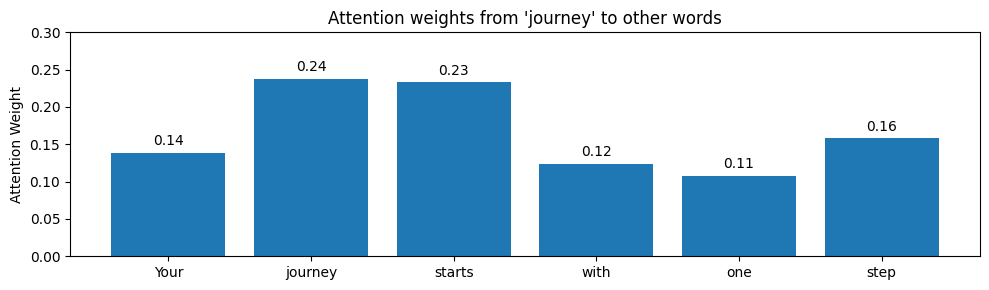

In [5]:
# Visualize attention weights
plt.figure(figsize=(10, 3))
plt.bar(words, attn_weights_2.numpy())
plt.title("Attention weights from 'journey' to other words")
plt.ylabel("Attention Weight")
plt.ylim(0, 0.3)
for i, (word, weight) in enumerate(zip(words, attn_weights_2)):
    plt.text(i, weight + 0.01, f"{weight:.2f}", ha='center')
plt.tight_layout()
plt.show()

## Step 4: Compute Context Vector

📢 **Say this:**
> "Finally, we compute the **context vector** - a weighted sum of all word embeddings based on attention weights. This is the 'enriched' representation of 'journey'!"

💡 **Formula:**
$$z^{(i)} = \sum_j \alpha_{ij} \cdot x^{(j)}$$

In [6]:
# Compute context vector for "journey"
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

print(f"Original 'journey' embedding: {inputs[1]}")
print(f"Context vector for 'journey': {context_vec_2}")
print("\n💡 The context vector is similar but incorporates information from other words!")

Original 'journey' embedding: tensor([0.5500, 0.8700, 0.6600])
Context vector for 'journey': tensor([0.4419, 0.6515, 0.5683])

💡 The context vector is similar but incorporates information from other words!


## Computing Attention for ALL Words (Matrix Form)

📢 **Say this:**
> "Computing one word at a time is slow. Let's use matrix multiplication to compute ALL attention weights at once!"

In [7]:
# Compute all attention scores at once: inputs @ inputs.T
attn_scores = inputs @ inputs.T

print("Attention scores matrix:")
print(attn_scores)
print(f"\nShape: {attn_scores.shape} (6 words × 6 words)")

Attention scores matrix:
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

Shape: torch.Size([6, 6]) (6 words × 6 words)


In [8]:
# Apply softmax row-wise
attn_weights = torch.softmax(attn_scores, dim=-1)

print("Attention weights matrix (rows sum to 1):")
print(attn_weights)
print(f"\nRow sums: {attn_weights.sum(dim=-1)}")

Attention weights matrix (rows sum to 1):
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

Row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


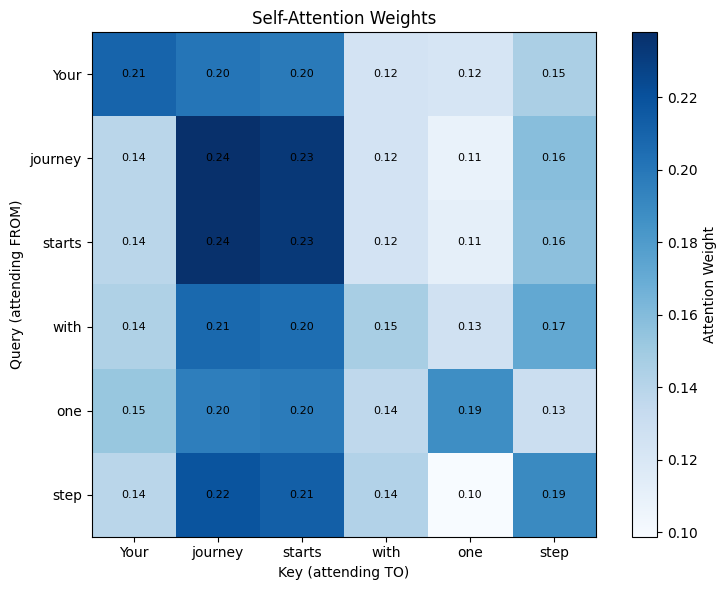

In [9]:
# Visualize the full attention matrix
plt.figure(figsize=(8, 6))
plt.imshow(attn_weights.numpy(), cmap='Blues')
plt.colorbar(label='Attention Weight')
plt.xticks(range(6), words)
plt.yticks(range(6), words)
plt.xlabel('Key (attending TO)')
plt.ylabel('Query (attending FROM)')
plt.title('Self-Attention Weights')

# Add text annotations
for i in range(6):
    for j in range(6):
        plt.text(j, i, f'{attn_weights[i,j]:.2f}', 
                ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()

In [10]:
# Compute all context vectors
all_context_vecs = attn_weights @ inputs

print("All context vectors:")
for word, context in zip(words, all_context_vecs):
    print(f"  {word:10} → {context}")

All context vectors:
  Your       → tensor([0.4421, 0.5931, 0.5790])
  journey    → tensor([0.4419, 0.6515, 0.5683])
  starts     → tensor([0.4431, 0.6496, 0.5671])
  with       → tensor([0.4304, 0.6298, 0.5510])
  one        → tensor([0.4671, 0.5910, 0.5266])
  step       → tensor([0.4177, 0.6503, 0.5645])


---
# Part 3: Self-Attention with Trainable Weights (Q, K, V)
---

## 📢 Instructor Script
> "The simple attention we built works, but it has no **learnable parameters**! The real attention uses trainable weight matrices for Queries, Keys, and Values."

> "Think of it this way:
> - **Query (Q)**: What am I looking for?
> - **Key (K)**: What do I contain?
> - **Value (V)**: What will I contribute if matched?"

## 🔑 The Q, K, V Transformation

💡 **Key Concept:**
```
For each input x:
  Query: q = x @ W_q  (what I'm searching for)
  Key:   k = x @ W_k  (what I can be found by)
  Value: v = x @ W_v  (what I'll contribute)
  
Attention: softmax(Q @ K.T / sqrt(d_k)) @ V
```

In [11]:
# Define dimensions
d_in = 3    # Input embedding dimension
d_out = 2   # Output dimension (can be different!)

# Create trainable weight matrices
torch.manual_seed(42)  # For reproducibility

W_query = nn.Parameter(torch.rand(d_in, d_out))
W_key = nn.Parameter(torch.rand(d_in, d_out))
W_value = nn.Parameter(torch.rand(d_in, d_out))

print(f"W_query shape: {W_query.shape}")
print(f"W_key shape: {W_key.shape}")
print(f"W_value shape: {W_value.shape}")

W_query shape: torch.Size([3, 2])
W_key shape: torch.Size([3, 2])
W_value shape: torch.Size([3, 2])


In [12]:
# Compute Q, K, V for all inputs
queries = inputs @ W_query  # (6, 3) @ (3, 2) = (6, 2)
keys = inputs @ W_key
values = inputs @ W_value

print(f"Queries shape: {queries.shape}")
print(f"Keys shape: {keys.shape}")
print(f"Values shape: {values.shape}")

Queries shape: torch.Size([6, 2])
Keys shape: torch.Size([6, 2])
Values shape: torch.Size([6, 2])


## ⚡ Scaled Dot-Product Attention

📢 **Say this:**
> "We add one important detail: **scaling**. Without it, dot products get very large for high dimensions, causing softmax to have extreme values. We divide by √d_k."

💡 **The Full Formula:**
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [13]:
# Compute attention scores
attn_scores = queries @ keys.T  # (6, 2) @ (2, 6) = (6, 6)
print(f"Attention scores (before scaling):\n{attn_scores}")

# Scale by sqrt(d_k)
d_k = keys.shape[-1]
attn_scores_scaled = attn_scores / (d_k ** 0.5)
print(f"\nAttention scores (after scaling by √{d_k}={d_k**0.5:.2f}):\n{attn_scores_scaled}")

Attention scores (before scaling):
tensor([[1.8033, 2.2486, 2.2247, 1.1941, 1.1672, 1.5103],
        [2.7084, 3.3338, 3.3013, 1.7563, 1.7869, 2.1966],
        [2.6993, 3.3251, 3.2925, 1.7525, 1.7789, 2.1933],
        [1.4408, 1.7618, 1.7454, 0.9243, 0.9596, 1.1492],
        [1.7754, 2.2317, 2.2067, 1.1910, 1.1353, 1.5164],
        [1.6295, 1.9707, 1.9539, 1.0266, 1.1023, 1.2637]],
       grad_fn=<MmBackward0>)

Attention scores (after scaling by √2=1.41):
tensor([[1.2751, 1.5900, 1.5731, 0.8444, 0.8254, 1.0679],
        [1.9152, 2.3574, 2.3344, 1.2419, 1.2635, 1.5533],
        [1.9087, 2.3512, 2.3281, 1.2392, 1.2579, 1.5509],
        [1.0188, 1.2457, 1.2342, 0.6536, 0.6785, 0.8126],
        [1.2554, 1.5781, 1.5604, 0.8422, 0.8028, 1.0723],
        [1.1523, 1.3935, 1.3816, 0.7259, 0.7794, 0.8936]],
       grad_fn=<DivBackward0>)


In [14]:
# Apply softmax
attn_weights = torch.softmax(attn_scores_scaled, dim=-1)
print(f"Attention weights:\n{attn_weights}")
print(f"\nRow sums: {attn_weights.sum(dim=-1)}")

Attention weights:
tensor([[0.1719, 0.2355, 0.2315, 0.1117, 0.1096, 0.1397],
        [0.1723, 0.2681, 0.2620, 0.0879, 0.0898, 0.1200],
        [0.1721, 0.2679, 0.2618, 0.0881, 0.0898, 0.1203],
        [0.1750, 0.2196, 0.2171, 0.1215, 0.1245, 0.1424],
        [0.1704, 0.2353, 0.2312, 0.1127, 0.1084, 0.1419],
        [0.1772, 0.2255, 0.2228, 0.1157, 0.1220, 0.1368]],
       grad_fn=<SoftmaxBackward0>)

Row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


In [16]:
# Compute context vectors (final output)
context_vecs = attn_weights @ values
print(f"Context vectors shape: {context_vecs.shape}")
print(f"\nContext vectors:\n{context_vecs}")

Context vectors shape: torch.Size([6, 2])

Context vectors:
tensor([[1.3751, 0.8610],
        [1.4201, 0.8892],
        [1.4198, 0.8890],
        [1.3533, 0.8476],
        [1.3746, 0.8606],
        [1.3620, 0.8532]], grad_fn=<MmBackward0>)


## 🎭 Causal Masking (for GPT-style models)

📢 **Say this:**
> "In GPT, we can't let words look at **future** words - that would be cheating! We use a causal mask to hide future tokens."

```
"The cat sat on the mat"

When predicting "mat", we can see: [The, cat, sat, on, the]
When predicting "sat", we can see: [The, cat]
When predicting "cat", we can see: [The]
```

In [17]:
# Create causal mask
seq_len = inputs.shape[0]
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
print("Causal mask (1 = masked, 0 = visible):")
print(mask)

Causal mask (1 = masked, 0 = visible):
tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [18]:
# Apply mask by setting masked positions to -infinity
masked_scores = attn_scores_scaled.masked_fill(mask.bool(), float('-inf'))
print("Masked attention scores:")
print(masked_scores)

Masked attention scores:
tensor([[1.2751,   -inf,   -inf,   -inf,   -inf,   -inf],
        [1.9152, 2.3574,   -inf,   -inf,   -inf,   -inf],
        [1.9087, 2.3512, 2.3281,   -inf,   -inf,   -inf],
        [1.0188, 1.2457, 1.2342, 0.6536,   -inf,   -inf],
        [1.2554, 1.5781, 1.5604, 0.8422, 0.8028,   -inf],
        [1.1523, 1.3935, 1.3816, 0.7259, 0.7794, 0.8936]],
       grad_fn=<MaskedFillBackward0>)


In [19]:
# Softmax with mask (future tokens get 0 attention)
causal_attn_weights = torch.softmax(masked_scores, dim=-1)
print("Causal attention weights:")
print(causal_attn_weights)

Causal attention weights:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3912, 0.6088, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2452, 0.3817, 0.3730, 0.0000, 0.0000, 0.0000],
        [0.2387, 0.2995, 0.2961, 0.1657, 0.0000, 0.0000],
        [0.1986, 0.2743, 0.2694, 0.1314, 0.1263, 0.0000],
        [0.1772, 0.2255, 0.2228, 0.1157, 0.1220, 0.1368]],
       grad_fn=<SoftmaxBackward0>)


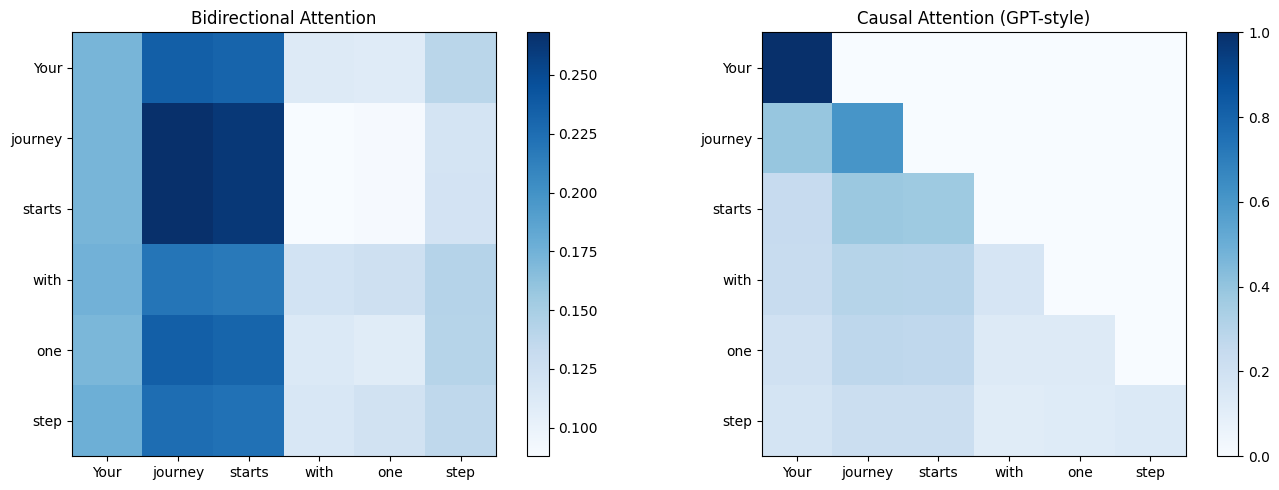

In [20]:
# Visualize causal attention
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regular attention
im1 = axes[0].imshow(attn_weights.detach().numpy(), cmap='Blues')
axes[0].set_title('Bidirectional Attention')
axes[0].set_xticks(range(6))
axes[0].set_yticks(range(6))
axes[0].set_xticklabels(words)
axes[0].set_yticklabels(words)
plt.colorbar(im1, ax=axes[0])

# Causal attention
im2 = axes[1].imshow(causal_attn_weights.detach().numpy(), cmap='Blues')
axes[1].set_title('Causal Attention (GPT-style)')
axes[1].set_xticks(range(6))
axes[1].set_yticks(range(6))
axes[1].set_xticklabels(words)
axes[1].set_yticklabels(words)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

---
## ☕ BREAK TIME (3:00 - 3:15)
---

---
# Part 4: Multi-Head Attention (60 min)
---

## 📢 Instructor Script
> "One attention head is good. But what if different parts of the sentence need different types of attention? Enter **Multi-Head Attention**!"

💡 **Key Insight:**
> "Think of it like looking at a painting with multiple experts:
> - Head 1: focuses on colors
> - Head 2: focuses on shapes
> - Head 3: focuses on composition
> 
> Together, they give a richer understanding!"

## 🏗️ Building a Single Attention Head

In [21]:
class CausalSelfAttention(nn.Module):
    """A single causal self-attention head."""
    
    def __init__(self, d_in, d_out, context_length, dropout=0.0):
        super().__init__()
        self.d_out = d_out
        
        # Learnable weight matrices
        self.W_query = nn.Linear(d_in, d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_value = nn.Linear(d_in, d_out, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # Register causal mask as buffer (not a parameter)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    
    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        
        # Compute Q, K, V
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        
        # Compute attention scores
        attn_scores = queries @ keys.transpose(-2, -1)
        
        # Scale
        attn_scores = attn_scores / (self.d_out ** 0.5)
        
        # Apply causal mask
        attn_scores = attn_scores.masked_fill(
            self.mask[:seq_len, :seq_len].bool(), float('-inf')
        )
        
        # Softmax and dropout
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Compute context vectors
        context = attn_weights @ values
        return context

In [22]:
# Test single head
torch.manual_seed(42)

d_in = 768   # GPT-2 embedding dimension
d_out = 64   # Head dimension
context_length = 1024

single_head = CausalSelfAttention(d_in, d_out, context_length)

# Create sample input: batch=2, seq_len=10, d_in=768
sample_input = torch.randn(2, 10, d_in)
output = single_head(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"\n✅ Single attention head works!")

Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 64])

✅ Single attention head works!


## 🎯 Multi-Head Attention

📢 **Say this:**
> "Multi-Head Attention runs several attention heads in parallel, then concatenates their outputs. GPT-2 uses 12 heads!"

In [23]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Causal Self-Attention."""
    
    def __init__(self, d_in, d_out, context_length, num_heads, dropout=0.0):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        # Combined projections for efficiency
        self.W_query = nn.Linear(d_in, d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_value = nn.Linear(d_in, d_out, bias=False)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        
        # Causal mask
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    
    def forward(self, x):
        batch_size, seq_len, d_in = x.shape
        
        # Project to Q, K, V
        Q = self.W_query(x)  # (batch, seq_len, d_out)
        K = self.W_key(x)
        V = self.W_value(x)
        
        # Reshape to (batch, num_heads, seq_len, head_dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention
        attn_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        attn_scores = attn_scores.masked_fill(
            self.mask[:seq_len, :seq_len].bool(), float('-inf')
        )
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        context = attn_weights @ V  # (batch, num_heads, seq_len, head_dim)
        
        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_out)
        
        # Final projection
        output = self.out_proj(context)
        return output

In [24]:
# Test Multi-Head Attention
torch.manual_seed(42)

# GPT-2 config
d_model = 768
num_heads = 12
context_length = 1024

mha = MultiHeadAttention(
    d_in=d_model,
    d_out=d_model,
    context_length=context_length,
    num_heads=num_heads,
    dropout=0.1
)

# Sample input
sample_input = torch.randn(2, 10, d_model)
output = mha(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"\nNumber of heads: {num_heads}")
print(f"Head dimension: {d_model // num_heads}")
print(f"\n✅ Multi-Head Attention works!")

Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 768])

Number of heads: 12
Head dimension: 64

✅ Multi-Head Attention works!


In [25]:
# Count parameters
num_params = sum(p.numel() for p in mha.parameters())
print(f"Multi-Head Attention parameters: {num_params:,}")
print(f"\nBreakdown:")
print(f"  W_query: {d_model * d_model:,}")
print(f"  W_key:   {d_model * d_model:,}")
print(f"  W_value: {d_model * d_model:,}")
print(f"  out_proj: {d_model * d_model + d_model:,} (with bias)")

Multi-Head Attention parameters: 2,360,064

Breakdown:
  W_query: 589,824
  W_key:   589,824
  W_value: 589,824
  out_proj: 590,592 (with bias)


---
# Part 5: Exercises & Day 1 Wrap-up (15 min)
---

## 🎯 Exercise 1: Attention Visualization

Run attention on a real sentence and visualize what each head attends to:

In [26]:
# TODO: Modify MHA to also return attention weights, then visualize them
# Hint: Store attn_weights before dropout and return it alongside output

## 🎯 Exercise 2: Understand the Math

Compute the dimensions at each step for GPT-2 (124M):
- d_model = 768
- num_heads = 12
- seq_len = 256
- batch_size = 8

In [27]:
# TODO: Calculate and print the shape at each step
batch_size = 8
seq_len = 256
d_model = 768
num_heads = 12
head_dim = d_model // num_heads

print(f"Input shape: ({batch_size}, {seq_len}, {d_model})")
print(f"After Q/K/V projection: ({batch_size}, {seq_len}, {d_model})")
print(f"After reshape for heads: ({batch_size}, {num_heads}, {seq_len}, {head_dim})")
print(f"Attention scores: ({batch_size}, {num_heads}, {seq_len}, {seq_len})")
print(f"Context vectors: ({batch_size}, {num_heads}, {seq_len}, {head_dim})")
print(f"After concat: ({batch_size}, {seq_len}, {d_model})")
print(f"Final output: ({batch_size}, {seq_len}, {d_model})")

Input shape: (8, 256, 768)
After Q/K/V projection: (8, 256, 768)
After reshape for heads: (8, 12, 256, 64)
Attention scores: (8, 12, 256, 256)
Context vectors: (8, 12, 256, 64)
After concat: (8, 256, 768)
Final output: (8, 256, 768)


---
## 📝 Session 2 Summary

📢 **Say this:**
> "Fantastic work today! We've built the heart of transformers. Let's recap:"

### Key Takeaways:

1. **Self-Attention** lets each token "look at" all other tokens
   - Attention scores: dot product of queries and keys
   - Attention weights: softmax-normalized scores
   - Context vectors: weighted sum of values

2. **Scaling** prevents gradient issues:
   - Divide by √d_k before softmax

3. **Causal Masking** for autoregressive models:
   - Can only attend to past tokens
   - Set future attention scores to -∞

4. **Multi-Head Attention**:
   - Multiple attention heads = richer representations
   - GPT-2 uses 12 heads, GPT-3 uses 96!

### Tomorrow's Preview:
> "Tomorrow we'll put attention into a complete GPT architecture and see it all work together!"

---
## 🏠 Homework

1. Run through this notebook again on your own
2. Try changing the number of heads and observe the effect
3. Read the original "Attention Is All You Need" paper (Section 3.2)

---
## 🔗 Resources

- [Attention Is All You Need (paper)](https://arxiv.org/abs/1706.03762)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [LLMs from Scratch - Chapter 3](https://github.com/rasbt/LLMs-from-scratch/tree/main/ch03)